# Import packages and CSV file

In [ ]:
print('all good')

In [4]:
import numpy as np
import pandas as pd
import math 
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.optimize import minimize
import pickle
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 10)

In [118]:
data = pd.read_csv('cricket.csv')
data.head()

,Match,Date,Innings,Over,Runs,Total.Runs,Innings.Total.Runs,Runs.Remaining,Total.Out,Innings.Total.Out,Outs.Remaining,Wickets.in.Hand,Run.Rate,Innings.Run.Rate,Run.Rate.Required,Initial.Run.Rate.Required,Target.Score,Day-night,At.Bat,Fielding,Home.Team,Away.Team,Stadium,Country,Total.Overs,Winning.Team,Toss.Winner,at.bat.wins,at.bat.won.toss,at.bat.at.home,at.bat.bat.first,chose_bat_1st,chose_bat_2nd,forced_bat_1st,forced_bat_2nd,new.game,Error.In.Data,common.support
0,65193,14/05/1999,1,1,4,4,204,200,0,10,10,10,4.0,4.08,-1.0,-1.0,-1,0,Sri Lanka,England,England,Sri Lanka,Lord's,England,50,England,England,0,0,0,1,0,0,1,0,1,0,1
1,65193,14/05/1999,1,2,2,6,204,198,0,10,10,10,3.0,4.08,-1.0,-1.0,-1,0,Sri Lanka,England,England,Sri Lanka,Lord's,England,50,England,England,0,0,0,1,0,0,1,0,0,0,1
2,65193,14/05/1999,1,3,3,9,204,195,0,10,10,10,3.0,4.08,-1.0,-1.0,-1,0,Sri Lanka,England,England,Sri Lanka,Lord's,England,50,England,England,0,0,0,1,0,0,1,0,0,0,1
3,65193,14/05/1999,1,4,2,20,204,184,0,10,10,10,5.0,4.08,-1.0,-1.0,-1,0,Sri Lanka,England,England,Sri Lanka,Lord's,England,50,England,England,0,0,0,1,0,0,1,0,0,0,1
4,65193,14/05/1999,1,5,6,37,204,167,0,10,10,10,7.4,4.08,-1.0,-1.0,-1,0,Sri Lanka,England,England,Sri Lanka,Lord's,England,50,England,England,0,0,0,1,0,0,1,0,0,0,1


In [119]:
with open('Removed.pkl', 'rb') as f:
    matches_to_remove = pickle.load(f)

In [110]:
matches_to_remove = list(set(matches_to_remove))
len(matches_to_remove)

130

# Remove affected matches

In [37]:
data.shape

(126768, 38)

In [120]:
data = data[~(data.Match.isin(matches_to_remove))]

In [98]:
data.shape

(123394, 38)

# Data Preparation

In [121]:
# data cleaning
data_first = data[data.Innings == 1].copy()

df1 = data_first[['Match', 'Over', 'Total.Runs', 'Innings.Total.Runs', 'Runs.Remaining', 'Wickets.in.Hand']].copy()
df1['Total.Overs'] = 50
df1['Overs.Remaining'] = df1['Total.Overs'] - df1['Over']
df1 = df1[['Match', 'Overs.Remaining', 'Runs.Remaining', 'Wickets.in.Hand']]

df2 = data_first[['Match', 'Over', 'Total.Runs', 'Innings.Total.Runs', 'Runs.Remaining', 'Wickets.in.Hand']].copy()
df2['Total.Overs'] = 50
df2 = df2.groupby('Match').first().reset_index()
df2['Wickets.in.Hand'] = 10
df2 = df2[['Match', 'Total.Overs', 'Innings.Total.Runs', 'Wickets.in.Hand']]
df2.columns = ['Match', 'Overs.Remaining', 'Runs.Remaining', 'Wickets.in.Hand']

df = pd.concat([df2, df1], axis = 0)
df.sort_values(['Match', 'Overs.Remaining'], ascending = [True, False], inplace = True)
df = df[['Overs.Remaining', 'Wickets.in.Hand', 'Runs.Remaining']]
df.columns = ['u', 'w', 'y']

X = df.copy()

In [122]:
# Compute Z0
Z = dict()

def computeZ0(w: int, data_first: pd.core.frame.DataFrame):
    if w == 10:
        return data_first.groupby('Match').first()['Innings.Total.Runs'].mean()
    else:
        return data_first[data_first['Wickets.in.Hand'] <= w].groupby('Match').first()['Runs.Remaining'].mean()
    
for w in range(10, -1, -1):
    Z[w] = computeZ0(w, data_first)
    print('Z0({}) = {}'.format(w, computeZ0(w, data_first)))

Z0(10) = 243.5877803557618
Z0(9) = 207.46249033255995
Z0(8) = 170.13302397525135
Z0(7) = 132.74863813229572
Z0(6) = 97.11968503937008
Z0(5) = 66.92610837438424
Z0(4) = 43.78776978417266
Z0(3) = 27.65240083507307
Z0(2) = 15.0390625
Z0(1) = 6.704545454545454
Z0(0) = 0.0


In [123]:
# Question 1
def fn(b):
#     global X
    t = X.copy()
    losses = t.apply(lambda row: (row['y'] - Z[row['w']] * (1 - np.exp(-b * row['u']))) ** 2, axis = 1)
    loss = losses.sum() / len(t)
#     print(loss)
    return loss

B = dict()
X_backup = X.copy()
for w in range(10, -1, -1):
    X = df[df.w == w].copy()
    result = minimize(fn, 0, method = 'L-BFGS-B')
    B[w] = result.x[0]
    print('b[{}] = {}'.format(w, B[w]))


b[10] = 0.06611616634609575
b[9] = 0.07260429876804946
b[8] = 0.09384762962121189
b[7] = 0.11955680306336565
b[6] = 0.17956804660675224
b[5] = 0.26192032385237196
b[4] = 0.4180252792257524
b[3] = 0.6752228145373727
b[2] = 1.0612850205673425
b[1] = 3.3210806523042575
b[0] = 0.0


In [17]:
B

{10: 0.07027896359882138,
 9: 0.07602349003782383,
 8: 0.09677089137834577,
 7: 0.1238074923390248,
 6: 0.18294400406098418,
 5: 0.2634104522344032,
 4: 0.41481921000379074,
 3: 0.664027169062772,
 2: 1.0235983232260188,
 1: 3.388560674061263,
 0: 0.9999999999999999}

In [124]:
# compute MSE for Question 1
losses = df.apply(lambda row: (row['y'] - Z[row['w']] * (1 - np.exp(-B[row['w']] * row['u']))) ** 2, axis = 1)
loss = losses.sum() / len(df)
print(loss)

1708.2813722315077


In [127]:
# Question 2
X = df[df.w > 0].copy()

def fn(L):
    global X
    t = X.copy()
    losses = t.apply(lambda row: (row['y'] - Z[row['w']] * (1 - np.exp(-L * row['u'] / Z[row['w']]))) ** 2, axis = 1)
    loss = losses.sum() / len(t)
    print(loss)
    return loss

res = minimize(fn, 0.35, method = 'L-BFGS-B')
L = res.x[0]
print('L = ', L)

L =  15.8965580133249


In [128]:
# compute MSE for Question 2
losses = X.apply(lambda row: (row['y'] - Z[row['w']] * (1 - np.exp(-L * row['u'] / Z[row['w']]))) ** 2, axis = 1)
loss = losses.sum() / len(X)
print(loss)

1719.3917052731285


In [63]:
for w in range(10, 0, -1):
    print('b[{}] = {}, L/Z0[{}] = {}'.format(w, B[w], w, L/Z[w]))

b[10] = 0.07104365371507507, L/Z0[10] = 0.0014737299971593599
b[9] = 0.07607912916603857, L/Z0[9] = 0.001732462319248924
b[8] = 0.09708601254569339, L/Z0[8] = 0.002113555291319857
b[7] = 0.12513408370263018, L/Z0[7] = 0.0027063632781717884
b[6] = 0.18561537581855722, L/Z0[6] = 0.003679244572624794
b[5] = 0.2669622248098945, L/Z0[5] = 0.005294277251452732
b[4] = 0.4216774118121888, L/Z0[4] = 0.008036988358993616
b[3] = 0.6766743404497069, L/Z0[3] = 0.01263095238095238
b[2] = 1.0403517297635705, L/Z0[2] = 0.023034833538840935
b[1] = 3.361093113851824, L/Z0[1] = 0.05213971778857275


In [125]:
df

,u,w,y
0,50,10,363
6107,49,10,359
6108,48,10,351
6109,47,10,347
6110,46,10,330
...,...,...,...
126532,8,4,15
126533,7,3,12
126534,6,3,7
126535,5,1,3


# Plots

In [130]:
B

{10: 0.06611616634609575,
 9: 0.07260429876804946,
 8: 0.09384762962121189,
 7: 0.11955680306336565,
 6: 0.17956804660675224,
 5: 0.26192032385237196,
 4: 0.4180252792257524,
 3: 0.6752228145373727,
 2: 1.0612850205673425,
 1: 3.3210806523042575,
 0: 0.0}

In [131]:
Z

{10: 243.5877803557618,
 9: 207.46249033255995,
 8: 170.13302397525135,
 7: 132.74863813229572,
 6: 97.11968503937008,
 5: 66.92610837438424,
 4: 43.78776978417266,
 3: 27.65240083507307,
 2: 15.0390625,
 1: 6.704545454545454,
 0: 0.0}

In [132]:
L

15.8965580133249

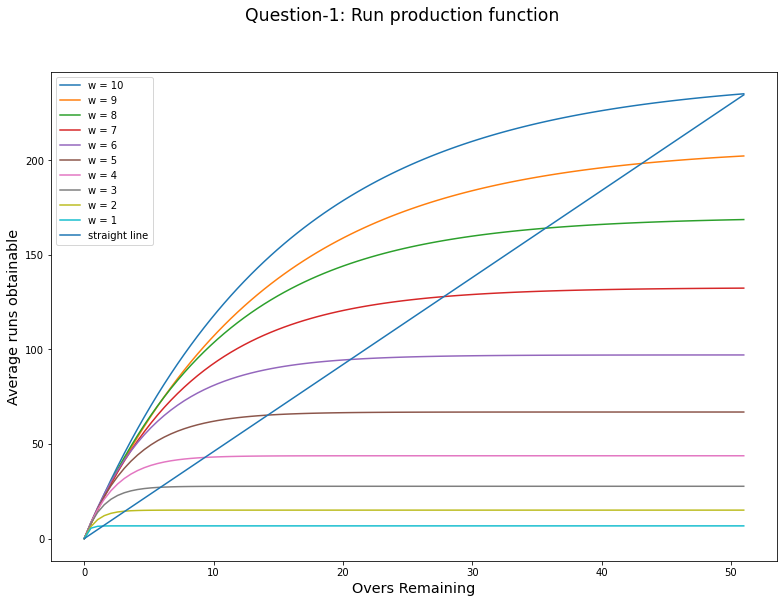

In [160]:
# Plot Question-1 curves 
plt.figure(figsize = (13,9))
for w in range(10, 0, -1):
    x = np.linspace(0,51,100)
    fx = Z[w] * (1 - np.exp(-B[w] * x))
    plt.plot(x, fx, label = 'w = {}'.format(w))

x = np.linspace(0, 51, 100)
slope = Z[10] * (1 - np.exp(-B[10] * 50)) / 51
fx = slope * x
plt.plot(x, fx, label = 'straight line')    
    
plt.legend(loc="upper left")
plt.suptitle('Question-1: Run production function', fontsize = 'xx-large')
plt.xlabel('Overs Remaining', fontsize = 'x-large')
plt.ylabel('Average runs obtainable', fontsize = 'x-large')
plt.show()

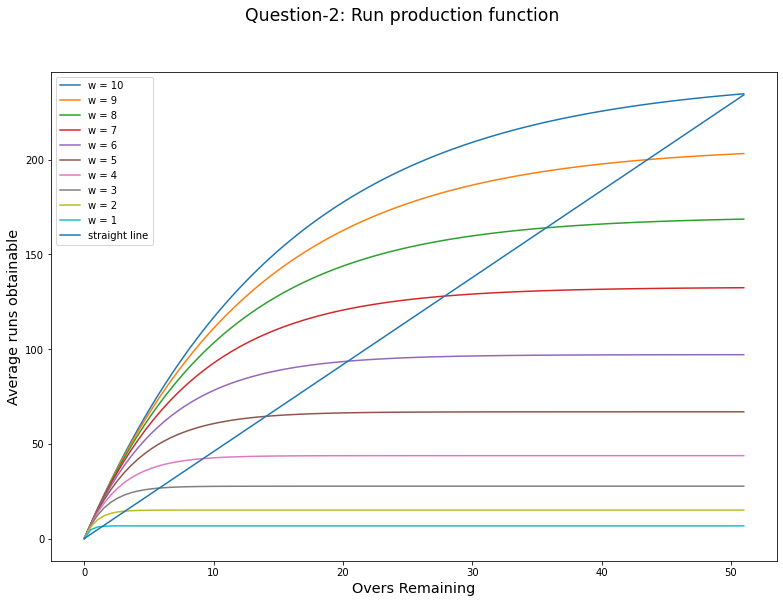

In [159]:
# Plot Question-2 curves 
plt.figure(figsize = (13,9))
for w in range(10, 0, -1):
    x = np.linspace(0,51,100)
    fx = Z[w] * (1 - np.exp(-L * x / Z[w]))
    plt.plot(x, fx, label = 'w = {}'.format(w))
    
# plotting a straight line for reference
x = np.linspace(0, 51, 100)
slope = Z[10] * (1 - np.exp(-L * 50 / Z[10])) / 51
fx = slope * x
plt.plot(x, fx, label = 'straight line')

plt.legend(loc="upper left")
plt.suptitle('Question-2: Run production function', fontsize = 'xx-large')
plt.xlabel('Overs Remaining', fontsize = 'x-large')
plt.ylabel('Average runs obtainable', fontsize = 'x-large')
plt.show()

# Compute Slopes at u = 0

In [148]:
# Question 1
for w in range(1, 11):
    # for w wickets, compute slope at u = 0
    slope = Z[w] * B[w]
    print('slope at w = {}: {}'.format(w, round(slope, 2)))

slope at w = 1: 22.27
slope at w = 2: 15.96
slope at w = 3: 18.67
slope at w = 4: 18.3
slope at w = 5: 17.53
slope at w = 6: 17.44
slope at w = 7: 15.87
slope at w = 8: 15.97
slope at w = 9: 15.06
slope at w = 10: 16.11


In [161]:
# Question 2
for w in range(1, 11):
    # for w wickets, compute slope at u = 0
    slope = L
    print('slope at w = {}: {}'.format(w, slope))

slope at w = 1: 15.8965580133249
slope at w = 2: 15.8965580133249
slope at w = 3: 15.8965580133249
slope at w = 4: 15.8965580133249
slope at w = 5: 15.8965580133249
slope at w = 6: 15.8965580133249
slope at w = 7: 15.8965580133249
slope at w = 8: 15.8965580133249
slope at w = 9: 15.8965580133249
slope at w = 10: 15.8965580133249
